<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/05-modern-training-techniques/04_hyperparameter_optimization_with_optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Hyperparameter optimization with Optuna

The improvements so far have focused on optimizing when we have gradients.
But hyperparameters are things we would like to optimize for which we do not have
any gradients, such as the initial learning rate $\eta$ to use and the value of the momentum
term $\mu$. 

We would also like to optimize the architecture of our networks: 

should we use two layers or three? 

How about the number of neurons in each hidden layer?

The first hyperparameter tuning method most people learn in machine learning
is called grid search. 

While valuable, grid search works well only for optimizing one or two variables at a time due to its exponential cost as more variables are added.

When training a neural network, we usually have at least three parameters we want to optimize(number of layers, number of neurons in each layer, and learning rate $\eta$). 

We instead use a newer approach—**Optuna**—to tuning hyperparameters, which works much better.

Optuna does a better job of hyperparameter optimization by
using a Bayesian technique to model the hyperparameter problem as its own machine learning task.

For Optuna, we define a function that we want to minimize (or
maximize), which takes as input a trial object. This trial object is used to get guesses
for each parameter we want to tune and returns a score at the end.

<img src='https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/05-modern-training-techniques/images/6.png?raw=1' width='600'/>

Let’s look at a toy function that we want to minimize:

$$ 
f(x, y) = abs(x-3)*(y+2)
$$

It’s easy to tell that one minimum exists at $x = 3$ and $y = -2$.

So now, let's try to find it with Optuna.

##Setup

In [ ]:
!pip install optuna

In [ ]:
from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

from sklearn.datasets import make_moons

import time

In [ ]:
!wget https://github.com/EdwardRaff/Inside-Deep-Learning/raw/main/idlmam.py

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import optuna

from idlmam import train_simple_network, Flatten, weight_reset, set_seed, run_epoch

In [5]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
from IPython.display import display_pdf
from IPython.display import Latex

torch.backends.cudnn.deterministic=True
set_seed(45)

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

##Dataset

We use the
Fashion-MNIST dataset because it is slightly more challenging while retaining the same
size and shape as the original MNIST corpus, which will let us accomplish some testing
in a reasonable time.

In [ ]:
epochs = 50
B = 256

train_data = torchvision.datasets.FashionMNIST("./data", train=True, transform=transforms.ToTensor(), download=True)
test_data = torchvision.datasets.FashionMNIST("./data", train=False, transform=transforms.ToTensor(), download=True)

training_loader = DataLoader(train_data, batch_size=B, shuffle=True)
testing_loader = DataLoader(test_data, batch_size=B)

##Training algorithem

Some problems take just a few epochs, others take hundreds to thousands, and
both of these factors change based on how much data you have. 

For these reasons, I don’t like requiring a learning rate schedule to always be used. I like to work without one first and then add one based on the problem at hand. 

However, we must always use some kind of optimizer. So if none is given, we  use a good default.

In [8]:
def train_network(model, loss_func, train_loader, val_loader=None, test_loader=None, 
                  score_funcs=None, epochs=50, device="cpu", checkpoint_file=None, 
                  lr_schedule=None, optimizer=None, disable_tqdm=False):
  """
  Train simple neural networks
    
  Keyword arguments:
  model -- the PyTorch model / "Module" to train
  loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
  train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs. 
  val_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
  test_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
  score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
  epochs -- the number of training epochs to perform
  device -- the compute lodation to perform training
  lr_schedule -- the learning rate schedule used to alter \eta as the model trains. If this is not None than the user must also provide the optimizer to use. 
  optimizer -- the method used to alter the gradients for learning
  """
  if score_funcs == None:
    score_funcs = {}

  tracking = ["epoch", "total time", "train loss"]

  if val_loader  is not None:
    tracking.append("val loss")

  if test_loader is not None:
    tracking.append("test loss")
  
  for eval_score in score_funcs:
    tracking.append("train " + eval_score)
    if val_loader is not None:
      tracking.append("val " + eval_score)
    if test_loader is not None:
      tracking.append("test " + eval_score)

  # How long have we spent in the training loop?
  total_train_time = 0
  results = {}
  # Initialize every item with an empty list
  for item in tracking:
    results[item] = []

  if optimizer == None:
    # AdamW optimizer is a good default optimizer
    optimizer = torch.optim.AdamW(model.parameters())

  # Place the model on the correct compute resource (CPU or GPU)
  model.to(device)

  # iterating through all the data (batches) multiple times (epochs)
  for epoch in tqdm(range(epochs), desc="Epoch", disable=disable_tqdm):
    # Put the model in training mode
    model = model.train()

    # train the model
    total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")
    
    results["total time"].append(total_train_time)
    results["epoch"].append(epoch)

    if val_loader is not None:
      #  Put the model to "evaluation" mode, b/c we don't want to make any updates!
      model = model.eval()
      with torch.no_grad():
        run_epoch(model, optimizer, val_loader, loss_func, device, results, score_funcs, prefix="val", desc="Validating")

    # In PyTorch, the convention is to update the learning rate after every epoch
    if lr_schedule is not None:
      if isinstance(lr_schedule, torch.optim.lr_scheduler.ReduceLROnPlateau):
        lr_schedule.step(results["val loss"][-1])
      else:
        lr_schedule.step()

    if test_loader is not None:
      model = model.eval()
      with torch.no_grad():
        run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing")

    # lets us save the model, the optimizer state, and other information, all in one object
    if checkpoint_file is not None:
      torch.save({
          "epoch": epoch,
          "model_state_dict": model.state_dict(),
          "optimizer_state_dict": optimizer.state_dict(),
          "results": results
      }, checkpoint_file)

  # Finally, convert the results into a pandas DataFrame
  return pd.DataFrame.from_dict(results)

##Optuna trail object

Optuna figures out how many hyperparameters exist by means of us using the trial
object to obtain a guess for each parameter. This happens with the suggest_uniform
function, which requires us to provide a range of possible values.

In [9]:
def toy_func(trial):
  # The below two calls ask optuna for two parameters, and definethe minimum and maximum value for each one
  x = trial.suggest_uniform("x", -10.0, 10.0)
  y = trial.suggest_uniform("y", -10.0, 10.0)
  # Now we can compute and return the result. Optuna will try to minimize this value
  return abs((x - 3) * (y + 2))

Now we can use the `create_study` function to build the task
and call optimize with the number of trials we want to let Optuna have to minimize
the function.

In [ ]:
# If you said direction='maximize' Optuna would try and maximize the value returned by toy_func
study = optuna.create_study(direction="minimize")
# We tell Optuna which function to minimize, and that it gets 100 attempts to do so
study.optimize(toy_func, n_trials=100)

We can access true answer using `study.best_params`, which contains a dict
object mapping the hyperparameters to the values that, in combination, gave the best result.

In [11]:
print(study.best_params)

{'x': 3.0505130497576554, 'y': -1.653112134896916}


We can use a contour plot to see an example.

In [12]:
optuna.visualization.plot_contour(study)

##Optuna with PyTorch

We do not want to go crazy, as optimizing without any
gradients is still very difficult and Optuna is not a magic bullet. But we can use Optuna
to help us make some decisions. 

For example, how many neurons should we have in
each layer, and how many layers?

1. Create train/validation splits
2. Ask Optuna to give us three critical hyperparameters
3. Define our model using the parameters
4. Compute and return the result from the validation split

In [13]:
def objective(trial):
  train_subset = int(len(train_data) * 0.8)
  test_subset = len(train_data) - train_subset 

  split = torch.utils.data.random_split(train_data, [train_subset, test_subset])

  train_loader = DataLoader(split[0], batch_size=B, shuffle=True)
  val_loader = DataLoader(split[1], batch_size=B, shuffle=False)

  # search hidden layer size
  n = trial.suggest_int("neurons_per_layer", 16, 256)
  layers = trial.suggest_int("hidden_layers", 1, 6)

  #How many values are in the input?
  D = 28*28 #28 * 28 images
  # How many channels are in the input?
  C = 1
  # How many classes are there?
  classes = 10

  # At least one hidden layer, that take in D inputs
  sequential_layers = [
    nn.Flatten(),
    nn.Linear(D, n),
    nn.Tanh()
  ]

  # Now lets add in a variable number of hidden layers, depending on what Optuna gave us for the "layers" parameter
  for _ in range(layers - 1):
    sequential_layers.append(nn.Linear(n, n))
    sequential_layers.append(nn.Tanh())

  # Output layer
  sequential_layers.append(nn.Linear(n, classes))

  # Now turn the list of layers into a PyTorch Sequential Module 
  fc_model = nn.Sequential(*sequential_layers)

  # What should our global learning rate be? Notice that we can ask for new hyper-parameters from optuna whenever we want
  eta_global = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)

  optimizer = torch.optim.AdamW(fc_model.parameters(), lr=eta_global)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs // 3)
  loss_func = nn.CrossEntropyLoss()

  results = train_network(fc_model, 
                          loss_func, 
                          train_loader,
                          epochs=10, 
                          test_loader=val_loader,
                          optimizer=optimizer,
                          lr_schedule=scheduler,
                          score_funcs={"Accuracy": accuracy_score},
                          device=device,
                          disable_tqdm=True)
  # A objective value linked with the Trial object
  return results["test Accuracy"].iloc[-1]

You must remember that this is a validation split and that we have not used
the test set. We should only use the test set after the hyperparameters have been found, to determine the overall accuracy.

Let's searches for the hyperparameters
for this problem.

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

In [15]:
print(study.best_params)

{'neurons_per_layer': 188, 'hidden_layers': 1, 'learning_rate': 0.009184554219247697}


Let's look at the progress Optuna made
over time and other views of the optimization process. 

Doing so can help us build some
intuition about the range of “good” parameters.

In [16]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

We might also want to get an idea of how each hyperparameter performs with respect
to the objective (accuracy). That can be done with a slice plot.

In [17]:
fig = optuna.visualization.plot_slice(study)
fig.show()

Optuna can also help you understand the interactions between hyperparameters. One
option is the `plot_contour()` function, which creates a grid showing how every combination
of two different hyperparameters impacts the results.

In [18]:
fig = optuna.visualization.plot_contour(study, params=["neurons_per_layer", "hidden_layers", "learning_rate"])
fig.show()

The other option is the
`plot_parallel_coordinate()` function, which shows all the results of every trial in one graph.

In [19]:
fig = optuna.visualization.plot_parallel_coordinate(study, params=["neurons_per_layer", "hidden_layers", "learning_rate"])
fig.show()

Now that we have trained our network, so we need to train a new model with this information to determine what final
validation accuracy you get on the true validation set.

In [20]:
D = 28 * 28       # input size
n = 188           # Hidden layer size
C= 1              # How many channels are in the input?
classes = 10      # How many classes are there?

# {'neurons_per_layer': 188, 'hidden_layers': 1, 'learning_rate': 0.009184554219247697}

In [21]:
fc_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(D, n),
    nn.Tanh(),
    nn.Linear(n, n),
    nn.Tanh(),
    nn.Linear(n, classes)
)

In [ ]:
eta_0 = 0.0091
loss_func = nn.CrossEntropyLoss()

fc_results = train_network(fc_model, 
                          loss_func, 
                          training_loader,
                          epochs=epochs, 
                          test_loader=testing_loader,
                          optimizer=torch.optim.SGD(fc_model.parameters(), lr=eta_0),
                          checkpoint_file="model.pt",
                          score_funcs={"Acc": accuracy_score},
                          device=device)

In [23]:
fc_results.head()

,epoch,total time,train loss,test loss,train Acc,test Acc
0,0,5.376148,1.911337,1.497075,0.493467,0.5895
1,1,12.118124,1.252498,1.085094,0.625050,0.6439
2,2,17.500884,0.975920,0.906203,0.672233,0.6756
3,3,22.891364,0.842025,0.809663,0.699717,0.7012
4,4,28.332964,0.764014,0.747706,0.727383,0.7242


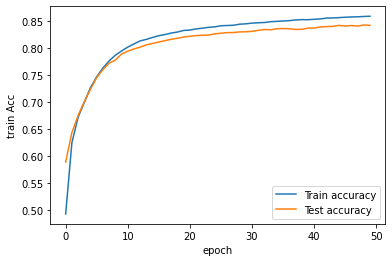

In [25]:
sns.lineplot(x="epoch", y="train Acc", data=fc_results, label="Train accuracy")
sns.lineplot(x="epoch", y="test Acc", data=fc_results, label="Test accuracy")

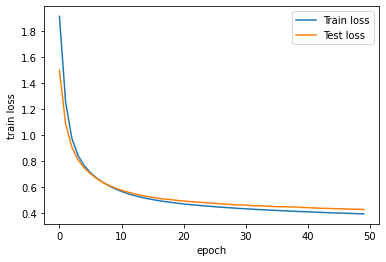

In [26]:
sns.lineplot(x="epoch", y="train loss", data=fc_results, label="Train loss")
sns.lineplot(x="epoch", y="test loss", data=fc_results, label="Test loss")

As we show, the training and testing curve is very smooth, so now our network is not oscillating and overfitting.

##Pruning trials with Optuna

Optuna supports the feature that is particularly useful when training neural
networks is pruning trials early. 

The idea is that optimizing a neural network is iterative:
we take multiple epochs through the dataset, and we (hopefully) improve with every
epoch. This is valuable information we are not using. If we can determine early in the
process that a model won’t pan out, we can save a lot of time.

We can accomplish this by calling `train_network` 10 times in a loop for 1 epoch each.

In [35]:
def objective_pruning(trial):
  train_subset = int(len(train_data) * 0.8)
  test_subset = len(train_data) - train_subset 

  split = torch.utils.data.random_split(train_data, [train_subset, test_subset])

  train_loader = DataLoader(split[0], batch_size=B, shuffle=True)
  val_loader = DataLoader(split[1], batch_size=B, shuffle=False)

  # search hidden layer size
  n = trial.suggest_int("neurons_per_layer", 16, 256)
  layers = trial.suggest_int("hidden_layers", 1, 6)

  #How many values are in the input?
  D = 28*28 #28 * 28 images
  # How many channels are in the input?
  C = 1
  # How many classes are there?
  classes = 10

  # At least one hidden layer, that take in D inputs
  sequential_layers = [
    nn.Flatten(),
    nn.Linear(D, n),
    nn.Tanh()
  ]

  # Now lets add in a variable number of hidden layers, depending on what Optuna gave us for the "layers" parameter
  for _ in range(layers - 1):
    sequential_layers.append(nn.Linear(n, n))
    sequential_layers.append(nn.Tanh())

  # Output layer
  sequential_layers.append(nn.Linear(n, classes))

  # Now turn the list of layers into a PyTorch Sequential Module 
  fc_model = nn.Sequential(*sequential_layers)

  # What should our global learning rate be? Notice that we can ask for new hyper-parameters from optuna whenever we want
  eta_global = trial.suggest_loguniform("learning_rate", 1e-6, 1e+2)

  optimizer = torch.optim.AdamW(fc_model.parameters(), lr=eta_global)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs // 3)
  loss_func = nn.CrossEntropyLoss()

  for epoch in range(10):
    results = train_network(fc_model, 
                            loss_func, 
                            train_loader,
                            epochs=1,             # Do just one epoch of training, but reuse the same model and optimizer
                            test_loader=val_loader,
                            optimizer=optimizer,
                            lr_schedule=scheduler,
                            score_funcs={"Accuracy": accuracy_score},
                            device=device,
                            disable_tqdm=True)
    # import pdb;pdb.set_trace()
    cur_accuracy = results["test Accuracy"].iloc[-1]
    # Lets Optuna know how well we are doing
    trial.report(cur_accuracy, epoch)

    # Asks Optuna if this looks hopeless
    if trial.should_prune():
      raise optuna.exceptions.TrialPruned()   # If so, stop trying

  return cur_accuracy

I’m going to run a new trial with Optuna but intentionally set
the number of neurons to go down to 1 (way too small) and the learning rate to go
up to $\eta = 100$ (way too big). 

This will create some really bad models that are easy to
prune out, just to show off this new pruning feature.

In [38]:
study2 = optuna.create_study(direction="maximize")
study2.optimize(objective_pruning, n_trials=20)   # n_trials=20 to give pruning more opportunities to occur

[I 2022-08-11 05:31:26,276] A new study created in memory with name: no-name-e8086b91-c3b2-4c53-8672-b9d09e78aa4b


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

[I 2022-08-11 05:32:28,198] Trial 0 finished with value: 0.58975 and parameters: {'neurons_per_layer': 117, 'hidden_layers': 3, 'learning_rate': 2.7313229244927976e-06}. Best is trial 0 with value: 0.58975.


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

[I 2022-08-11 05:33:24,145] Trial 1 finished with value: 0.89175 and parameters: {'neurons_per_layer': 118, 'hidden_layers': 1, 'learning_rate': 0.003523896765868023}. Best is trial 1 with value: 0.89175.


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

[I 2022-08-11 05:34:23,436] Trial 2 finished with value: 0.09766666666666667 and parameters: {'neurons_per_layer': 189, 'hidden_layers': 6, 'learning_rate': 1.039761618071628}. Best is trial 1 with value: 0.89175.


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

[I 2022-08-11 05:35:19,945] Trial 3 finished with value: 0.89075 and parameters: {'neurons_per_layer': 134, 'hidden_layers': 2, 'learning_rate': 0.0040617789771340415}. Best is trial 1 with value: 0.89175.


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

[I 2022-08-11 05:36:19,207] Trial 4 finished with value: 0.285 and parameters: {'neurons_per_layer': 165, 'hidden_layers': 5, 'learning_rate': 0.019018401503115043}. Best is trial 1 with value: 0.89175.


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

[I 2022-08-11 05:36:24,877] Trial 5 pruned. 


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

[I 2022-08-11 05:37:23,738] Trial 6 finished with value: 0.8760833333333333 and parameters: {'neurons_per_layer': 78, 'hidden_layers': 5, 'learning_rate': 0.002044090593349422}. Best is trial 1 with value: 0.89175.


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

[I 2022-08-11 05:37:29,410] Trial 7 pruned. 


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

[I 2022-08-11 05:38:27,689] Trial 8 finished with value: 0.8903333333333333 and parameters: {'neurons_per_layer': 185, 'hidden_layers': 3, 'learning_rate': 0.0016688642908692297}. Best is trial 1 with value: 0.89175.


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

[I 2022-08-11 05:38:33,766] Trial 9 pruned. 


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

[I 2022-08-11 05:38:39,522] Trial 10 pruned. 


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

[I 2022-08-11 05:38:45,123] Trial 11 pruned. 


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

[I 2022-08-11 05:38:50,995] Trial 12 pruned. 


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

[I 2022-08-11 05:38:56,852] Trial 13 pruned. 


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

[I 2022-08-11 05:39:13,590] Trial 14 pruned. 


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

[I 2022-08-11 05:39:19,393] Trial 15 pruned. 


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

[I 2022-08-11 05:39:42,153] Trial 16 pruned. 


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

[I 2022-08-11 05:39:47,923] Trial 17 pruned. 


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

[I 2022-08-11 05:39:53,870] Trial 18 pruned. 


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Testing:   0%|          | 0/47 [00:00<?, ?it/s]

[I 2022-08-11 05:40:00,431] Trial 19 pruned. 


We can have Optuna plot the results of all
the trials with their intermediate values to help us understand that better.

In [39]:
fig = optuna.visualization.plot_intermediate_values(study2)
fig.show()

It looks like all 10 trials were pruned after just 5 or 6 epochs through the dataset. That’s
very early in the process: Optuna has reduced the number of effective trials almost by half.

Early on, Optuna
lets bad models run to completion because it does not yet know they are bad models.
Only after more trials and seeing much better models does it learn that the original
ones could have been pruned. 

So pruning does not avoid all bad models, but it can
avoid many of them.

In [40]:
print(study2.best_params)

{'neurons_per_layer': 118, 'hidden_layers': 1, 'learning_rate': 0.003523896765868023}


Now, let's train new model with these parameters.

In [ ]:
D = 28 * 28       # input size
n = 118           # Hidden layer size
C= 1              # How many channels are in the input?
classes = 10      # How many classes are there?

fc_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(D, n),
    nn.Tanh(),
    nn.Linear(n, classes)
)

eta_0 = 0.00352
loss_func = nn.CrossEntropyLoss()

fc_results = train_network(fc_model, 
                          loss_func, 
                          training_loader,
                          epochs=epochs, 
                          test_loader=testing_loader,
                          optimizer=torch.optim.SGD(fc_model.parameters(), lr=eta_0),
                          checkpoint_file="model.pt",
                          score_funcs={"Acc": accuracy_score},
                          device=device)

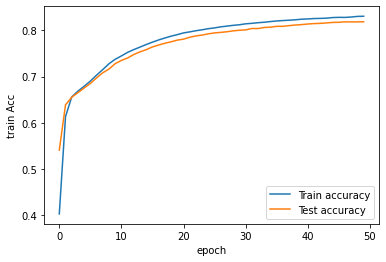

In [42]:
sns.lineplot(x="epoch", y="train Acc", data=fc_results, label="Train accuracy")
sns.lineplot(x="epoch", y="test Acc", data=fc_results, label="Test accuracy")

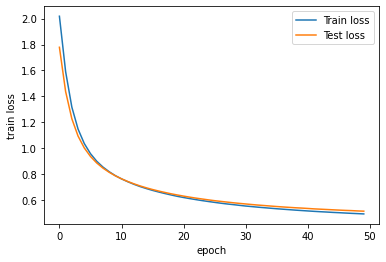

In [43]:
sns.lineplot(x="epoch", y="train loss", data=fc_results, label="Train loss")
sns.lineplot(x="epoch", y="test loss", data=fc_results, label="Test loss")

Again we show, the training and testing curve is very smooth, so now our network is not oscillating and overfitting.